**Import Libraries**

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from wordcloud import WordCloud
import re
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

**Load Dataset**

In [3]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')
df_news_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/agnews/train.csv')
df_news_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/agnews/test.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Understand & Visualization Data**

**Undersatnd Data**

In [5]:
print(df_news_train.head())

   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  


In [6]:
print(df_news_train.describe())

         Class Index
count  120000.000000
mean        2.500000
std         1.118039
min         1.000000
25%         1.750000
50%         2.500000
75%         3.250000
max         4.000000


In [7]:
df_news_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [8]:
df_news_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  7600 non-null   int64 
 1   Title        7600 non-null   object
 2   Description  7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.3+ KB


In [9]:
df_news_train['Class Index'].unique()


array([3, 4, 2, 1])

In [10]:
df_news_test['Class Index'].unique()


array([3, 4, 2, 1])

In [11]:
df_news_train['Class Index'] = df_news_train['Class Index'] - 1
df_news_test['Class Index'] = df_news_test['Class Index'] - 1

In [12]:
print(df_news_train['Class Index'].unique())
print(df_news_test['Class Index'].unique())

[2 3 1 0]
[2 3 1 0]


In [13]:
df_news_train.columns


Index(['Class Index', 'Title', 'Description'], dtype='object')

In [14]:
df_news_train['Description'][1]


'Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.'

**Visualization**

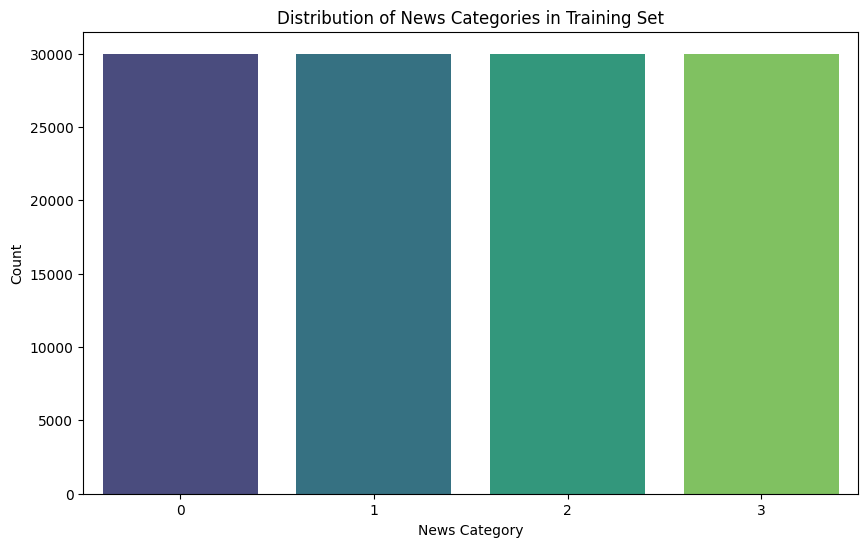

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Class Index', data=df_news_train, palette='viridis')
plt.title('Distribution of News Categories in Training Set')
plt.xlabel('News Category')
plt.ylabel('Count')
plt.show()

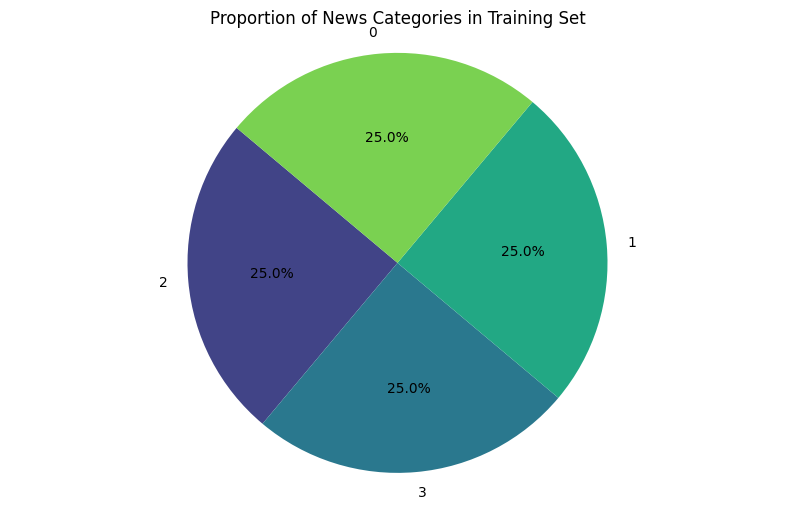

In [16]:
plt.figure(figsize=(10, 6))
plt.pie(df_news_train['Class Index'].value_counts(),
        labels=df_news_train['Class Index'].unique(),
        autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', n_colors=len(df_news_train['Class Index'].unique())))
plt.title('Proportion of News Categories in Training Set')
plt.axis('equal')
plt.show()

**Data Preprocessing**

In [17]:
df_news_train['text'] = df_news_train['Title'] + ' ' + df_news_train['Description']
df_news_test['text'] = df_news_test['Title'] + ' ' + df_news_test['Description']

In [18]:
df_news_train.drop(columns=['Title', 'Description'], inplace=True)
df_news_test.drop(columns=['Title', 'Description'], inplace=True)

In [19]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # remove HTML tags and special characters
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text, language='english')

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back to a single string
    text= ' '.join(tokens)
    return text

In [20]:
df_news_train.drop_duplicates(subset=['text'], inplace=True)
df_news_test.drop_duplicates(subset=['text'], inplace=True)
df_news_train.dropna(subset=['text'], inplace=True)
df_news_test.dropna(subset=['text'], inplace=True)

In [21]:
df_news_train['text'] = df_news_train['text'].apply(preprocess_text)
df_news_test['text'] = df_news_test['text'].apply(preprocess_text)

In [22]:
# 1 represents World, 2 represents Sports, 3 represents Business and 4 represents Sci/Tech.
def getcode(num):
    if num == 0:
        return 'World'
    elif num == 1:
        return 'Sports'
    elif num == 2:
        return 'Business'
    elif num == 3:
        return 'Sci/Tech'
    else:
        return 'Unknown'

In [23]:
df_news_train['text'][1]


'carlyle look toward commercial aerospace reuters reuters private investment firm carlyle groupwhich reputation making welltimed occasionallycontroversial play defense industry quietly placedits bet another part market'

**Encoding Using TF_IDF**

In [24]:
TfidfVector = TfidfVectorizer(max_features=5000)
X_train = TfidfVector.fit_transform(df_news_train['text'])

X_test = TfidfVector.transform(df_news_test['text'])
y_train = df_news_train['Class Index']
y_test = df_news_test['Class Index']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(120000, 5000) (120000,)
(7600, 5000) (7600,)


**Logistic Regression Model**

In [24]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [25]:
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=[getcode(i) for i in df_news_train['Class Index'].unique()]))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

    Business       0.92      0.90      0.91      1900
    Sci/Tech       0.95      0.98      0.96      1900
      Sports       0.88      0.87      0.87      1900
       World       0.88      0.88      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600

Accuracy: 0.9064473684210527


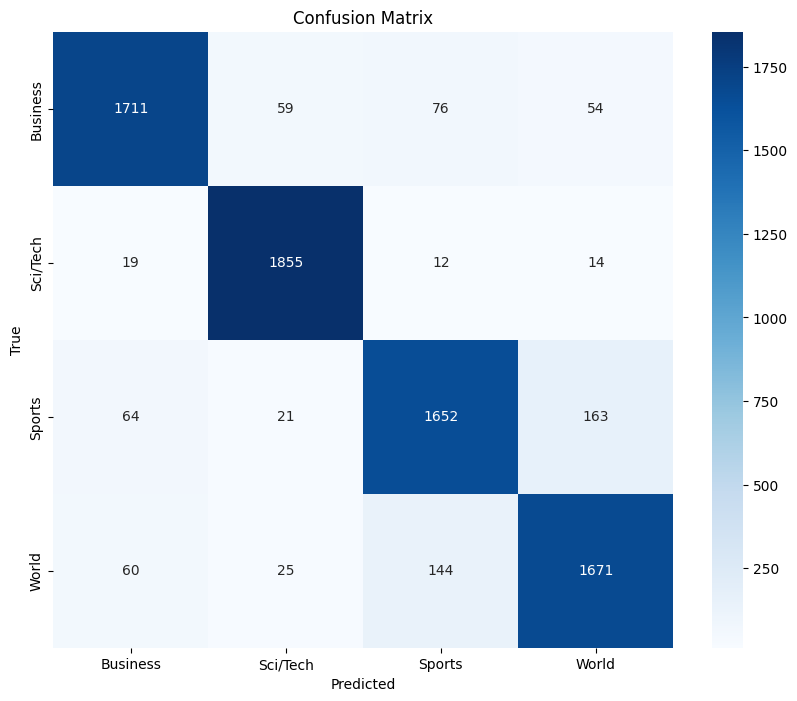

In [26]:
cm = confusion_matrix(y_test, y_pred)
labels = [getcode(i) for i in df_news_train['Class Index'].unique()]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


**SVM Model the best model**

In [27]:

SVC_model = SVC(kernel='linear')
SVC_model.fit(X_train, y_train)

SVC(kernel='linear')

In [28]:
y_pred_svc = SVC_model.predict(X_test)
print(classification_report(y_test, y_pred_svc, target_names=[getcode(i) for i in df_news_train['Class Index'].unique()]))
print("Accuracy:", accuracy_score(y_test, y_pred_svc))

              precision    recall  f1-score   support

    Business       0.92      0.90      0.91      1900
    Sci/Tech       0.95      0.98      0.96      1900
      Sports       0.87      0.87      0.87      1900
       World       0.88      0.89      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600

Accuracy: 0.9068421052631579


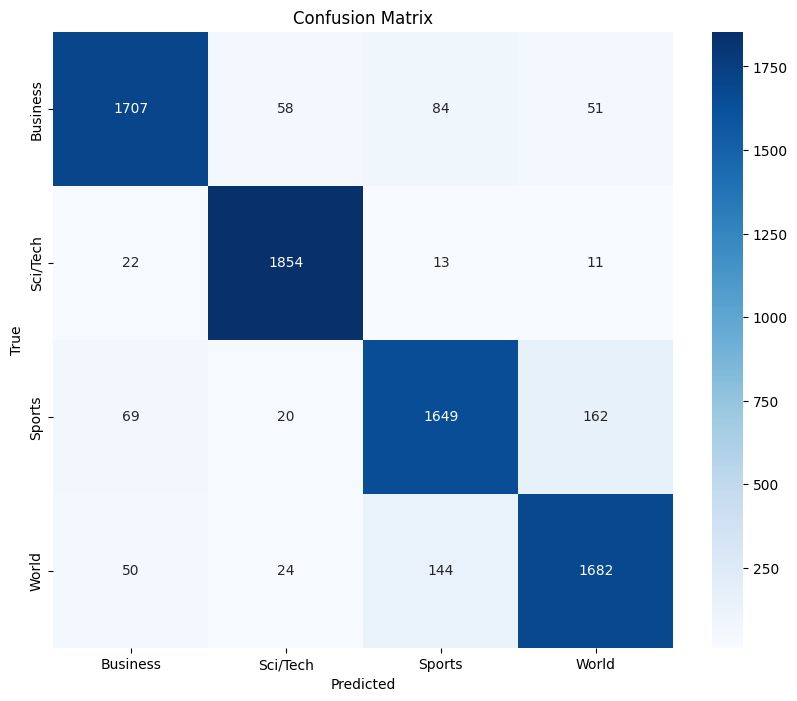

In [29]:
cm = confusion_matrix(y_test, y_pred_svc)
labels = [getcode(i) for i in df_news_train['Class Index'].unique()]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Random Forest Classifier Model**

In [30]:
RFC_model = RandomForestClassifier(n_estimators=100, random_state=42)
RFC_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
y_pred_RFC = RFC_model.predict(X_test)
print(classification_report(y_test, y_pred_RFC, target_names=[getcode(i) for i in df_news_train['Class Index'].unique()]))
print("Accuracy:", accuracy_score(y_test, y_pred_RFC))

              precision    recall  f1-score   support

    Business       0.90      0.88      0.89      1900
    Sci/Tech       0.92      0.96      0.94      1900
      Sports       0.86      0.85      0.85      1900
       World       0.87      0.84      0.85      1900

    accuracy                           0.89      7600
   macro avg       0.88      0.89      0.88      7600
weighted avg       0.88      0.89      0.88      7600

Accuracy: 0.8851315789473684


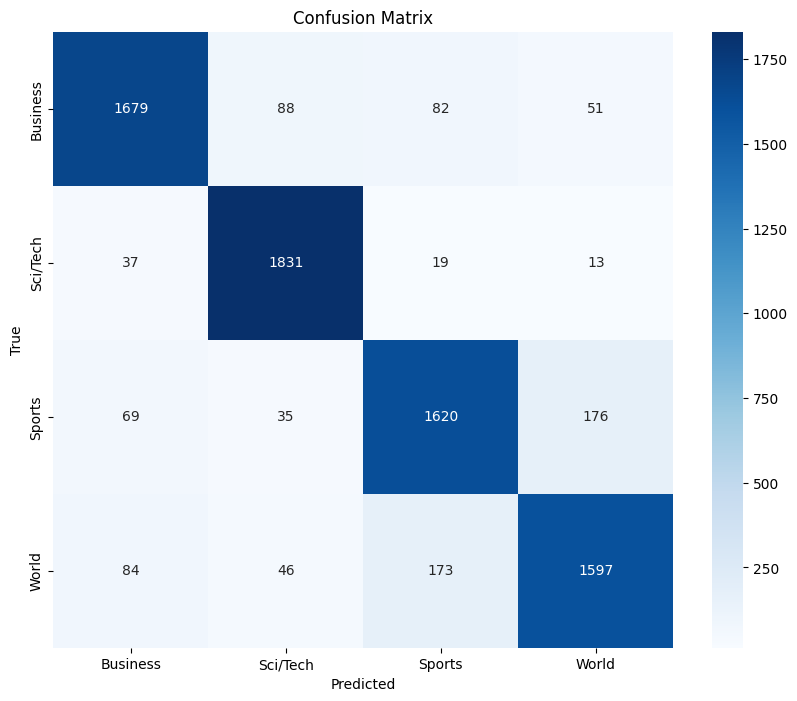

In [32]:
cm = confusion_matrix(y_test, y_pred_RFC)
labels = [getcode(i) for i in df_news_train['Class Index'].unique()]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**XGB Classifier Model**

In [33]:
XGB_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
XGB_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [34]:
y_pred_XGB = XGB_model.predict(X_test)
print(classification_report(y_test, y_pred_XGB, target_names=[getcode(i) for i in df_news_train['Class Index'].unique()]))
print("Accuracy:", accuracy_score(y_test, y_pred_XGB))

              precision    recall  f1-score   support

    Business       0.91      0.89      0.90      1900
    Sci/Tech       0.93      0.95      0.94      1900
      Sports       0.86      0.85      0.86      1900
       World       0.85      0.86      0.85      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Accuracy: 0.8880263157894737


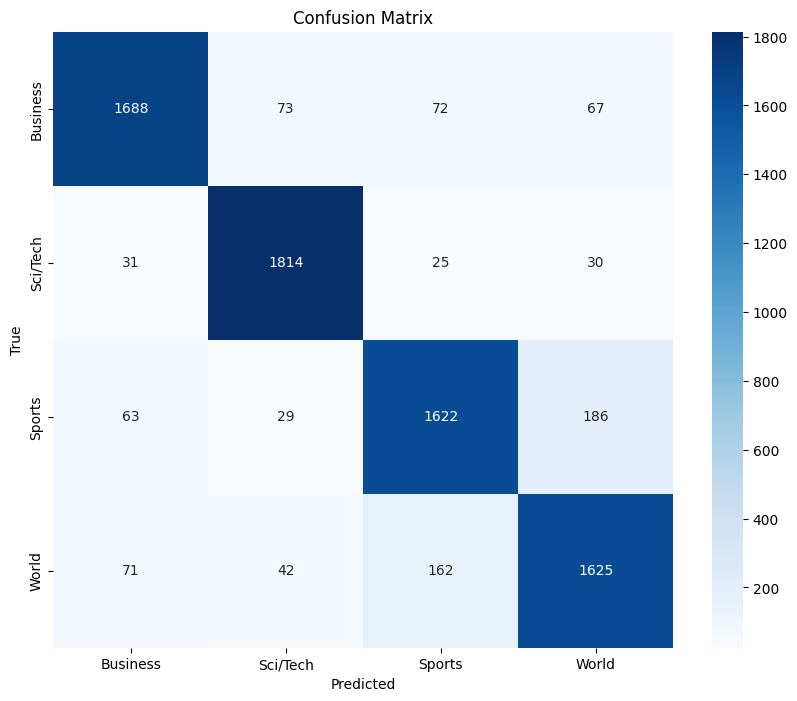

In [35]:
cm = confusion_matrix(y_test, y_pred_XGB)
labels = [getcode(i) for i in df_news_train['Class Index'].unique()]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**LGBM Classifier model**

In [36]:
LGBM_model = LGBMClassifier()
LGBM_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 7.976441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 479127
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 5000
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


LGBMClassifier()

In [37]:
y_pred_LGBM = LGBM_model.predict(X_test)
print(classification_report(y_test, y_pred_LGBM, target_names=[getcode(i) for i in df_news_train['Class Index'].unique()]))
print("Accuracy:", accuracy_score(y_test, y_pred_LGBM))

              precision    recall  f1-score   support

    Business       0.91      0.89      0.90      1900
    Sci/Tech       0.93      0.96      0.95      1900
      Sports       0.87      0.86      0.86      1900
       World       0.87      0.86      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.89      0.90      0.89      7600
weighted avg       0.89      0.90      0.89      7600

Accuracy: 0.8951315789473684


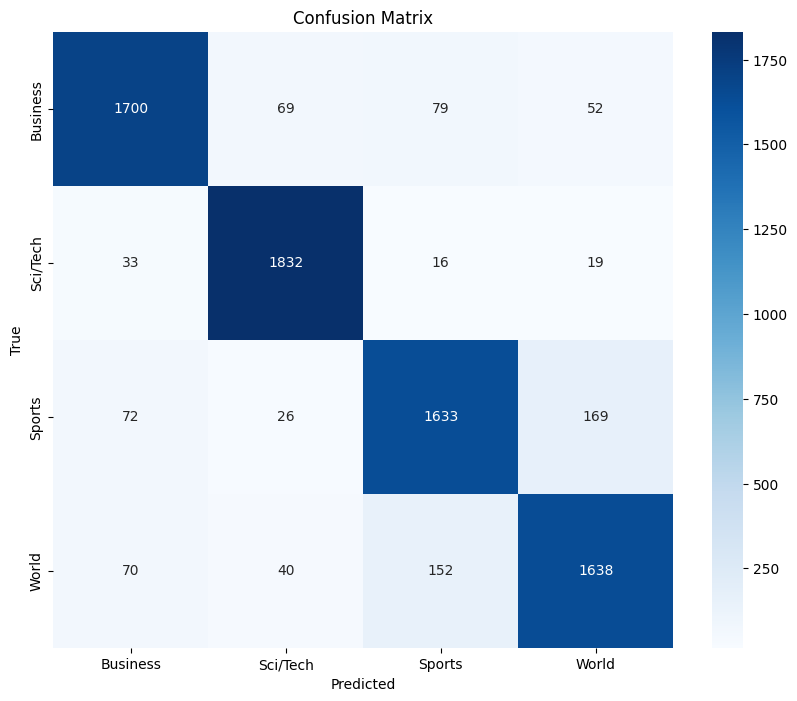

In [38]:
cm = confusion_matrix(y_test, y_pred_LGBM)
labels = [getcode(i) for i in df_news_train['Class Index'].unique()]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Deep Learning NN Model**

In [25]:
x_dence = X_train.toarray()
y_dence = to_categorical(y_train)
model_NN = Sequential([
    Dense(564, activation='relu', input_shape=(x_dence.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_dence.shape[1], activation='softmax')
])
model_NN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 564)            │     2,820,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 564)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       144,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,006,616 (11.47 MB)

 Trainable params: 3,006,616 (11.47 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
x_dence = X_train.toarray()
y_dence = to_categorical(y_train)
model_NN = Sequential([
    Dense(564, activation='relu', input_shape=(x_dence.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_dence.shape[1], activation='softmax')
])

model_NN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_NN.fit(x_dence, y_dence, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 214s 35ms/step - accuracy: 0.8403 - loss: 0.4394 - val_accuracy: 0.8973 - val_loss: 0.2953
Epoch 2/50
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 213s 35ms/step - accuracy: 0.9244 - loss: 0.2348 - val_accuracy: 0.9042 - val_loss: 0.2840
Epoch 3/50
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 212s 35ms/step - accuracy: 0.9383 - loss: 0.1903 - val_accuracy: 0.9037 - val_loss: 0.2987
Epoch 4/50
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 261s 35ms/step - accuracy: 0.9545 - loss: 0.1422 - val_accuracy: 0.9033 - val_loss: 0.3088
Epoch 5/50
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 264s 36ms/step - accuracy: 0.9639 - loss: 0.1139 - val_accuracy: 0.9002 - val_loss: 0.3722


In [27]:
Model_trial_results=pd.DataFrame(model_NN.history.history)

Model_trial_results

,accuracy,loss,val_accuracy,val_loss
0,0.886573,0.339800,0.897292,0.295260
1,0.922083,0.240512,0.904167,0.283961
2,0.937625,0.193586,0.903708,0.298686
3,0.951083,0.153545,0.903292,0.308789
4,0.962188,0.118399,0.900208,0.372228


<Axes: >

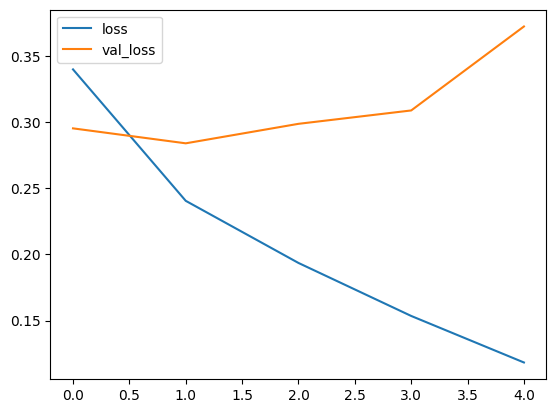

In [28]:
Model_trial_results[['loss','val_loss']].plot()

<Axes: >

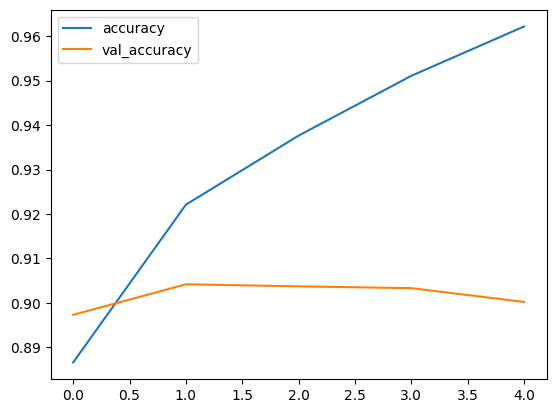

In [29]:
Model_trial_results[['accuracy','val_accuracy']].plot()


In [30]:
model_NN.evaluate(x_dence,y_dence)


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.9388 - loss: 0.1913


[0.19413314759731293, 0.9375583529472351]

In [31]:
y_dence_test = to_categorical(y_test)
y_pred_NN = model_NN.predict(X_test.toarray())
y_pred_NN_classes = np.argmax(y_pred_NN, axis=1)
print(classification_report(y_test, y_pred_NN_classes, target_names=[getcode(i) for i in df_news_train['Class Index'].unique()]))
print("Accuracy:", accuracy_score(y_test, y_pred_NN_classes))

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

    Business       0.93      0.89      0.91      1900
    Sci/Tech       0.94      0.98      0.96      1900
      Sports       0.88      0.87      0.88      1900
       World       0.88      0.90      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600

Accuracy: 0.9088157894736842


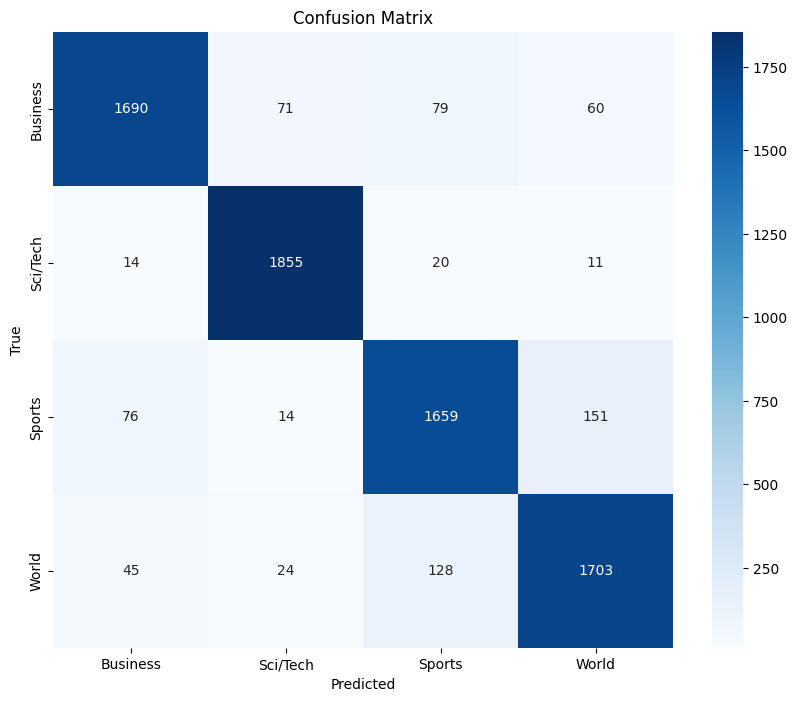

In [32]:
cm = confusion_matrix(y_test, y_pred_NN_classes)
labels = [getcode(i) for i in df_news_train['Class Index'].unique()]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [33]:
test_loss, test_accuracy = model_NN.evaluate(X_test.toarray(), y_dence_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9081 - loss: 0.2885
Test Loss: 0.2828212380409241
Test Accuracy: 0.9088158011436462


**Word Cloud Visualization**

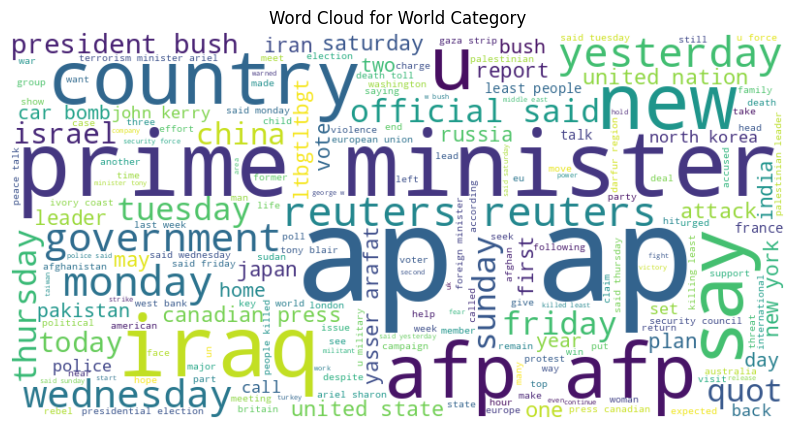

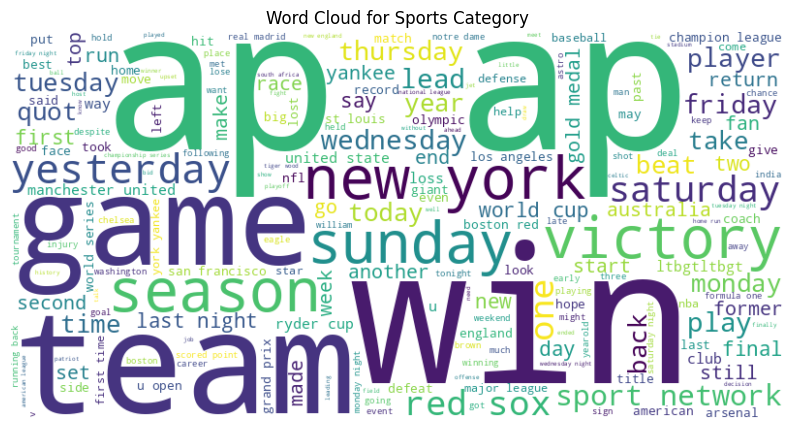

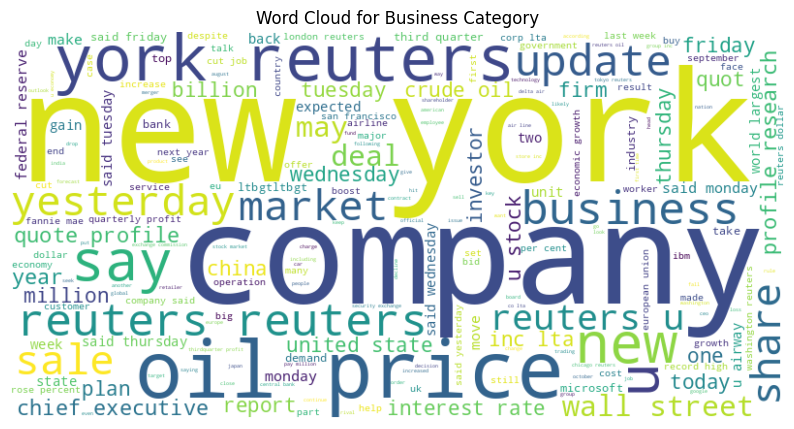

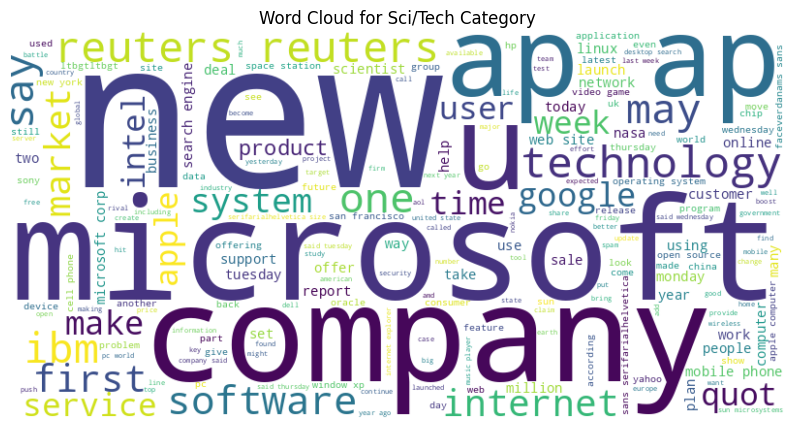

In [34]:
for i in range(0, 4):
    text = ' '.join(df_news_train[df_news_train['Class Index'] == i]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {getcode(i)} Category')
    plt.show()

***Demo***

In [41]:
# ===== Demo AG News classifier (Gradio) tích hợp Colab + Drive =====
import os
from pathlib import Path
import joblib
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
import gradio as gr

# ----- Mount Google Drive -----
from google.colab import drive
drive.mount('/content/drive')

# ----- Cấu hình đường dẫn -----
PIPELINE_PATH = Path("/content/drive/MyDrive/Colab Notebooks/agnews/svm_pipeline.pkl")
TRAIN_CSV_PATH = Path('/content/drive/MyDrive/Colab Notebooks/agnews/train.csv')
MAX_FEATURES = 5000
TRAIN_SAMPLE = 50000
RANDOM_STATE = 42

LABEL_MAP = {0: "World", 1: "Sports", 2: "Business", 3: "Science/Technology"}

# ----- Hàm train pipeline -----
def train_pipeline_from_csv(train_csv_path, sample_size=None):
    print(f"[INFO] Huấn luyện pipeline từ {train_csv_path} ...")
    df = pd.read_csv(train_csv_path)
    if 'text' not in df.columns:
        if 'Title' in df.columns and 'Description' in df.columns:
            df['text'] = df['Title'].fillna('') + ' ' + df['Description'].fillna('')
        else:
            text_cols = [c for c in df.columns if c.lower() in ('title','description','content','text')]
            if text_cols:
                df['text'] = df[text_cols].astype(str).agg(' '.join, axis=1)
            else:
                raise ValueError("Không tìm thấy cột text hợp lệ trong CSV.")
    label_col = None
    for cand in ['Class Index', 'class_index', 'label', 'Label', 'class', 'target']:
        if cand in df.columns:
            label_col = cand
            break
    if label_col is None:
        label_col = df.columns[-1]
        print(f"[WARN] Không tìm thấy cột nhãn chuẩn, dùng cột cuối: {label_col}")
    X = df['text'].astype(str)
    y = df[label_col]
    if y.dtype.kind in 'i' and y.min() >= 1 and y.max() <= 4:
        y = y - 1
    if sample_size is not None and sample_size > 0 and sample_size < len(X):
        X, _, y, _ = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=RANDOM_STATE)
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(1,2))),
        ("clf", LinearSVC(max_iter=2000))
    ])
    pipeline.fit(X, y)
    print("[INFO] Huấn luyện pipeline xong.")
    return pipeline

# ----- Load pipeline nếu có, nếu không train từ CSV -----
pipeline = None
if PIPELINE_PATH.exists():
    try:
        print(f"[INFO] Load pipeline từ {PIPELINE_PATH} ...")
        pipeline = joblib.load(PIPELINE_PATH)
        print("[INFO] Load pipeline thành công.")
    except Exception as e:
        print("[WARN] Không thể load pipeline:", e)

if pipeline is None:
    if TRAIN_CSV_PATH.exists():
        pipeline = train_pipeline_from_csv(TRAIN_CSV_PATH, sample_size=TRAIN_SAMPLE)
        joblib.dump(pipeline, PIPELINE_PATH)
        print(f"[INFO] Lưu pipeline vào {PIPELINE_PATH}")
    else:
       raise FileNotFoundError("""Không tìm thấy pipeline và file train.csv.""")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] Huấn luyện pipeline từ /content/drive/MyDrive/Colab Notebooks/agnews/train.csv ...
[INFO] Huấn luyện pipeline xong.
[INFO] Lưu pipeline vào /content/drive/MyDrive/Colab Notebooks/agnews/svm_pipeline.pkl


In [43]:


def predict_label(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Vui lòng nhập văn bản."
    pred = pipeline.predict([text])[0]
    try:
        label = LABEL_MAP.get(int(pred), str(pred))
    except Exception:
        label = str(pred)
    return label

title = "Demo - Phân loại chuyên mục tin tức (AG News)"
description = "Nhập tiêu đề + mô tả (hoặc văn bản) của bài báo, nhấn Predict để xem chuyên mục dự đoán."

iface = gr.Interface(
    fn=predict_label,
    inputs=gr.Textbox(lines=6, placeholder="Nhập tiêu đề + mô tả..."),
    outputs="text",
    title=title,
    description=description,
    examples=[
        ["Apple unveils the new iPhone with AI features"],
        ["Manchester United wins the match"]
    ],
    allow_flagging="never"
)

print("[INFO] Khởi chạy Gradio demo ...")
iface.launch(share=True)  # share=True để có link public trong Colab


[INFO] Khởi chạy Gradio demo ...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4782d3e0b30e233f4f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
